<a href="https://colab.research.google.com/github/Adi8885/RecurrentNets/blob/master/Hotel_reviews_sentiment_analysis_Doc2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import time
import os
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as Dataset
import torch.autograd as autograd
from torch.utils.data import Dataset, DataLoader
import torchvision


import nltk
nltk.download('punkt')
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report , accuracy_score , confusion_matrix

%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [10]:
data = pd.read_csv('./Hotel_Reviews_small.csv' , 
                   low_memory = False , 
                   compression = 'gzip',
                  nrows = 100000)
data.head()

,review,liked
0,Good location near metro station The room was...,1
1,We did not know it was 2 single beds never se...,0
2,The porters where very polite and helpful,1
3,Wifi was not working properly and no mobile s...,0
4,The WC Bath had not fan to let air out so som...,0


In [11]:
#remove html Tags

st_time = time.time()
data['review'] = data['review'].str.lower()
data['review'] = data['review'].str.replace('<br','')
data['review'] = data['review'].str.replace('/>','')
data['review'] = data['review'].str.replace('[^\w\s]','')

#remove html Tags
special_chars = """!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""
data['review'] = data['review'].apply(lambda x: " ".join(x for x in x.split() if x not in special_chars))

#remove numbers
numbers = '0123456789'
data['review'] = data['review'].apply(lambda x: " ".join(x for x in x.split() if x not in numbers))


#Remove stopwords
#stop = stopwords.words('english')
#data['review'] = data['review'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

print(' time taken to process : {} seconds'.format(round(time.time() - st_time ,2)))
data.head()

 time taken to process : 1.16 seconds


,review,liked
0,good location near metro station the room was ...,1
1,we did not know it was single beds never seen ...,0
2,the porters where very polite and helpful,1
3,wifi was not working properly and no mobile si...,0
4,the wc bath had not fan to let air out so some...,0


In [12]:
data['review_length'] = data['review'].apply(lambda x: len(str(x).split(" ")))
data.head()

,review,liked,review_length
0,good location near metro station the room was ...,1,42
1,we did not know it was single beds never seen ...,0,12
2,the porters where very polite and helpful,1,7
3,wifi was not working properly and no mobile si...,0,43
4,the wc bath had not fan to let air out so some...,0,37


In [13]:
print('min sentence Length : {}'.format(data.review_length.min()))
print('max sentence Length : {}'.format(data.review_length.max()))
print('mean sentence Length : {}'.format(data.review_length.mean()))
print('median sentence Length : {}'.format(data.review_length.median()))

min sentence Length : 1
max sentence Length : 390
mean sentence Length : 19.81121
median sentence Length : 12.0


In [14]:
st_time = time.time()
sentence_list = []
for i in data['review']:
    sentence_list.append(i)
print('sentence corpus : {}'.format(len(sentence_list)))
print('time taken to process : {} seconds'.format(round(time.time() - st_time ,2)))

sentence corpus : 100000
time taken to process : 0.03 seconds


In [15]:
st_time = time.time()
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(sentence_list)]
print('time taken to get tagged data : {} seconds'.format(round(time.time() - st_time ,2)))

time taken to get tagged data : 13.06 seconds


In [16]:
max_epochs = 1
vec_size = 256
alpha = 0.025
workers = os.cpu_count()

model = Doc2Vec(vector_size=vec_size,
                alpha=alpha, 
                min_alpha=0.0025,
                min_count=1,
                dm =1,
                workers = workers)
st_time = time.time() 
model.build_vocab(tagged_data)
print('time taken to build vocab : {} seconds'.format(round(time.time() - st_time ,2)))

time taken to build vocab : 24.01 seconds


In [17]:
print_every = 1
for epoch in range(max_epochs):
    st_time = time.time() 

    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.epochs)
    
    # decrease the learning rate
    model.alpha -= 0.002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha
    
    if epoch % print_every == 0 :
        print('iteration {} in {} seconds'.format(epoch , round(time.time() - st_time , 2)))

model.save("doc2vec.model")
print("Model Saved")

iteration 0 in 45.6 seconds


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Model Saved


In [18]:
total_records = data.shape[0]
embeddings_matrix = np.zeros((total_records , vec_size))
embeddings_matrix.shape

(100000, 256)

In [19]:
Y = data.liked.values
Y.shape

(100000,)

In [20]:
print_every = 10000
ctr = 0
st_time = time.time()
for idx in data.index :
    text = data.loc[idx].review.split(' ')
    vector = model.infer_vector(text)
    embeddings_matrix[idx] += vector
    ctr+=1
    if ctr % print_every == 0 :
        print('records done : {}/{} \t time : {}'.format(ctr , total_records , round(time.time() - st_time ,2)))
        st_time = time.time()

np.save(arr = embeddings_matrix ,  file = 'embeddings_matrix' , allow_pickle = True)

records done : 10000/100000 	 time : 9.45
records done : 20000/100000 	 time : 9.39
records done : 30000/100000 	 time : 9.23
records done : 40000/100000 	 time : 9.08
records done : 50000/100000 	 time : 9.24
records done : 60000/100000 	 time : 9.21
records done : 70000/100000 	 time : 9.28
records done : 80000/100000 	 time : 9.33
records done : 90000/100000 	 time : 9.31
records done : 100000/100000 	 time : 9.24


In [21]:
total_records = embeddings_matrix.shape[0]
train_percent = 0.9
val_percent = 0.05
test_percent = (1 - (train_percent + val_percent))

train_idx = int(train_percent * total_records)
test_idx = int(test_percent * total_records)
val_idx = int(val_percent * total_records)

x_train = embeddings_matrix[0 : train_idx]
y_train = Y[0 : train_idx]
print( ' x_train : {}  y_train : {}'.format(x_train.shape , y_train.shape))

x_val = embeddings_matrix[ train_idx : (train_idx + val_idx)]
y_val = Y[ train_idx : (train_idx + val_idx)]
print( ' x_val : {}  y_val : {}'.format(x_val.shape , y_val.shape))

x_test = embeddings_matrix[(train_idx + val_idx) : ]
y_test = Y[(train_idx + val_idx) : ]
print( ' x_test : {}  y_test : {}'.format(x_test.shape , y_test.shape))

 x_train : (90000, 256)  y_train : (90000,)
 x_val : (5000, 256)  y_val : (5000,)
 x_test : (5000, 256)  y_test : (5000,)


In [0]:
batch_size = 100

x_train = torch.tensor(x_train)
y_train = torch.tensor(y_train)
train_dataset = torch.utils.data.TensorDataset(x_train ,y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

x_val = torch.tensor(x_val)
y_val = torch.tensor(y_val)
val_dataset = torch.utils.data.TensorDataset(x_val ,y_val)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

x_test = torch.tensor(x_test)
y_test = torch.tensor(y_test)
test_dataset = torch.utils.data.TensorDataset(x_test ,y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [0]:
torch.save(val_dataloader, 'val_dataset.dataloader')
torch.save(test_dataloader, 'test_dataset.dataloader')
torch.save(train_dataloader, 'train_dataset.dataloader')

In [24]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('CUDA available, training on GPU')
else :
    device = torch.device("cpu")
    print('cuda NOT available, training on CPU') 
    
#device = torch.device("cpu")

cuda NOT available, training on CPU


In [25]:
input_size = vec_size
hidden_size = vec_size
batch_size = batch_size
drop_out_probability = 0.25

output_size = 2


class NN_Classifier(nn.Module):
    def __init__(self , input_size , hidden_size , output_size):
        super(NN_Classifier ,self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        #Input sequence of embedded word vectors
        
        # Inputs to hidden layer linear transformation
        self.fc1 = nn.Linear(in_features = input_size , out_features = hidden_size)
        self.fc2 = nn.Linear(in_features = hidden_size , out_features = hidden_size)
        
        #Droput layer before output
        self.dropout1 = nn.Dropout(p = drop_out_probability)
        self.dropout2 = nn.Dropout(p = drop_out_probability)
        
        # Output layer, 10 units - one for each digit
        self.out = nn.Linear(in_features = hidden_size , out_features = output_size)
        
    def forward(self,x):
        
        x = self.fc1(x)
        x = F.relu(x)
        
        #Dropout layer
        x = self.dropout1(x)
        
        #2nd hidden layer
        x = self.fc2(x)
        x = F.relu(x)
        
        #Droupout Layer
        #x = self.dropout2(x)
        
        #Output layer
        x = self.out(x)
        
        return x
    
model = NN_Classifier(input_size = input_size 
                            , hidden_size = hidden_size
                            , output_size = output_size )
model.double()

NN_Classifier(
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (out): Linear(in_features=256, out_features=2, bias=True)
)

In [26]:
epochs = 10
loss_fn = F.cross_entropy

learning_rate = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
print_every = 1000
model.to(device)


# to track the average training loss per epoch as the model trains
avg_train_losses = []
# to track the average validation loss per epoch as the model trains
avg_valid_losses = [] 
patience_ctr = 0
patience = 2


st_time = time.time()
    
for epoch in range(0,epochs):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []

    batch = 0
    #loss = 0
    st_time = time.time()
    model.train()
    for x, y in train_dataloader :
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        y_pred = model(x)
        
        #y_pred = y_pred.unsqueeze(0)
        loss = loss_fn(y_pred , y)

        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        if (batch % print_every == 0):
            print('epoch: {}/{}\tbatch: {}/{}\ttrain loss : {}\ttime : {} secs '.format(epoch, 
                                                                                       epochs , 
                                                                                       batch,
                                                                                       len(train_dataloader) , 
                                                                                       loss.item() , 
                                                                                       round(time.time() - st_time , 2)))
            
        batch +=1

    #Calculate Validation loss
    val_acc = 0
    model = model.eval()
    for x_v, y_v in val_dataloader :
        x_v = x_v.to(device)
        y_v = y_v.to(device)
        
        y_pred = model(x_v)
        loss = loss_fn(y_pred , y_v)
        
        valid_losses.append(loss.item())
    
    # calculate average loss over an epoch
    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)

    #Early stopping
    if valid_loss > train_loss:
        patience_ctr +=1
        print('patience_ctr : {}'.format(patience_ctr))
        if patience_ctr >= patience:
            print('early stoppping since valid_loss > train_loss')
            break
    else :
        patience_ctr = 0
    
    epoch_len = len(str(epochs))
    print('\nepoch : {}/{}\t train_loss :{}\t validation loss : {}\n'.format(epoch , 
                                                                           epochs, 
                                                                           train_loss , 
                                                                           valid_loss))
    
            
    print('epoch : {}/{} \t train loss : {} \t time required : {} secs'.format(epoch, 
                                                                          epochs, 
                                                                          loss.item(),
                                                                          round(time.time() - st_time , 2)))

epoch: 0/10	batch: 0/900	train loss : 0.7004441205902723	time : 0.25 secs 

epoch : 0/10	 train_loss :0.4309041326690528	 validation loss : 0.3699398547117967

epoch : 0/10 	 train loss : 0.3233923727693297 	 time required : 6.36 secs
epoch: 1/10	batch: 0/900	train loss : 0.30278272362832737	time : 0.06 secs 

epoch : 1/10	 train_loss :0.3552090351382857	 validation loss : 0.3210260842588772

epoch : 1/10 	 train loss : 0.3039355855929297 	 time required : 6.22 secs
epoch: 2/10	batch: 0/900	train loss : 0.34577496010152964	time : 0.06 secs 

epoch : 2/10	 train_loss :0.322039609337288	 validation loss : 0.3060354025728915

epoch : 2/10 	 train loss : 0.3200921193880709 	 time required : 6.2 secs
epoch: 3/10	batch: 0/900	train loss : 0.3149237271556376	time : 0.06 secs 

epoch : 3/10	 train_loss :0.3069408553655567	 validation loss : 0.29201685743102673

epoch : 3/10 	 train loss : 0.27917752475916485 	 time required : 6.22 secs
epoch: 4/10	batch: 0/900	train loss : 0.3902377184222099	t

In [27]:
st_time = time.time()
ctr = 0
print_every = 5
model = model.eval()
for x_v, y_v in test_dataloader :
    x_v = x_v.to(device)
    #y_v = y_v.to(device)
   
    op = model(x_v)
    op = torch.argmax(F.softmax(op), dim = 1)
    if ctr == 0:
        y_pred = op
        y_actual = y_v
    else:
        y_pred = torch.cat((y_pred , op))
        y_actual = torch.cat((y_actual , y_v))
   
    ctr += 1
   
    if ctr % print_every == 0:
        print(ctr)
print('time taken for prediction :{} seconds'.format(time.time() - st_time ))

5
10
15
20
25
30
35
40
45
50
time taken for prediction :0.21219587326049805 seconds


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


              precision    recall  f1-score   support

           0       0.83      0.90      0.86      2168
           1       0.91      0.85      0.88      2832

    accuracy                           0.87      5000
   macro avg       0.87      0.88      0.87      5000
weighted avg       0.88      0.87      0.87      5000

accuracy : 0.8728


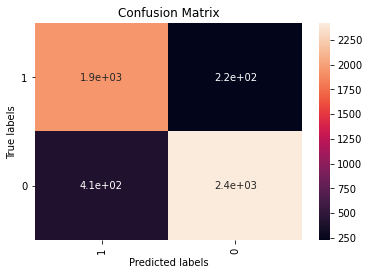

In [28]:
def my_classification_report(y_actual , y_predicted):
    print(classification_report(y_actual, y_pred))
    acc = accuracy_score(y_actual , y_predicted)
    print('accuracy : {}'.format(acc))
   
    conf_mat=confusion_matrix(y_actual, y_pred)
    #print(conf_mat)
    #plt.figure(figsize=(20,20))
    ax = plt.subplot()
    sns.heatmap(conf_mat, annot=True, ax = ax); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['1','0'])
    ax.yaxis.set_ticklabels(['1','0'])
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    #plt.savefig('conf_matrix.png')
    plt.show()

y_actual = y_actual.cpu().detach().numpy()
y_pred = y_pred.cpu().detach().numpy()
my_classification_report(y_actual = y_actual , y_predicted = y_pred)